In [1]:
import os
os.chdir('/home/jknize/main/repo/CSC578/detectron2')
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Simple ResNet object detection training using provided backbone from ImageNet pre-train

In [2]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog
# DatasetCatalog.remove("coco_train_subset")
# MetadataCatalog.remove("coco_train_subset")
register_coco_instances("coco_train_dog", {}, "../datasets/coco/annotations/dog_instances_train2017.json", "../datasets/coco/train2017_dog")
# DatasetCatalog.remove("coco_val_subset")
# MetadataCatalog.remove("coco_val_subset")
register_coco_instances("coco_val_dog", {}, "../datasets/coco/annotations/dog_instances_val2017.json", "../datasets/coco/val2017_dog")

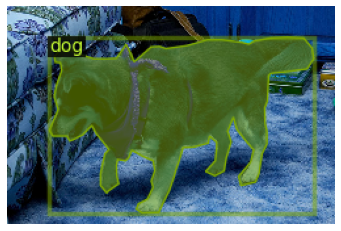

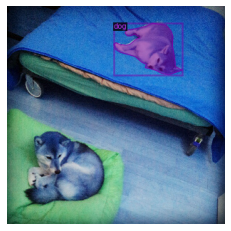

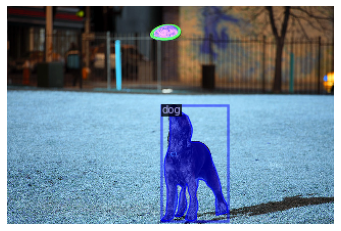

In [3]:
from detectron2.utils.visualizer import Visualizer
import random
import cv2
import matplotlib.pyplot as plt

my_dataset_metadata = MetadataCatalog.get("coco_train_dog")
my_dataset_metadata.thing_classes = ["dog"]
dataset_dicts = DatasetCatalog.get("coco_train_dog")

# Visualize 3 random images
for d in random.sample(dataset_dicts, 3):
    file_name = d['file_name']
    img = cv2.imread(d["file_name"]) 
    if img is None:
        print(f"Failed to load image: {d['file_name']}")
        continue 
     
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)  # Draw annotations on the image
    output_image = out.get_image()[:, :, ::-1]  # Convert back from BGR to RGB for matplotlib
    plt.imshow(output_image)
    plt.axis("off")  # Turn off axis
    plt.show()

Fine-tune weights to our COCO subset

In [ ]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, DefaultPredictor
import torch

# load simple ResNet-50 model without FPN
cfg = get_cfg()
cfg.merge_from_file("configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml") #ImageNet pre-trained
cfg.OUTPUT_DIR = "knize/output/dog_11-11"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 

cfg.DATASETS.TRAIN = ("coco_train_dog",)
cfg.DATASETS.TEST = ("coco_val_dog",)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

# solver config (guesses)
# 4385 dog images to train on
cfg.SOLVER.IMS_PER_BATCH = 8
# cfg.SOLVER.BASE_LR = 0.00025 # just going to try to use the base lr
cfg.SOLVER.MAX_ITER = 1200 # about 2 epochs
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
# cfg.SOLVER.STEPS = [] # disable learning decay

# run on GPU
cfg.MODEL.DEVICE = 'cuda'

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.model.to(cfg.MODEL.DEVICE)
# inputs = inputs.to(cfg.MODEL.DEVICE)

trainer.train()


[11/11 19:46:38 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  fc1000.{bias, weight}


[11/11 19:46:38 d2.engine.train_loop]: Starting training from iteration 0
[11/11 19:46:53 d2.utils.events]:  eta: 0:13:53  iter: 19  total_loss: 0.7432  loss_cls: 0.1277  loss_box_reg: 0.01706  loss_rpn_cls: 0.6232  loss_rpn_loc: 0.01299    time: 0.7067  last_time: 0.6945  data_time: 0.0501  last_data_time: 0.0044   lr: 0.00039962  max_mem: 11528M
[11/11 19:47:06 d2.utils.events]:  eta: 0:13:24  iter: 39  total_loss: 0.5608  loss_cls: 0.2312  loss_box_reg: 0.1159  loss_rpn_cls: 0.1496  loss_rpn_loc: 0.01284    time: 0.6857  last_time: 0.6297  data_time: 0.0316  last_data_time: 0.0495   lr: 0.00079922  max_mem: 11528M
[11/11 19:47:20 d2.utils.events]:  eta: 0:13:07  iter: 59  total_loss: 0.5524  loss_cls: 0.2219  loss_box_reg: 0.2341  loss_rpn_cls: 0.06038  loss_rpn_loc: 0.009955    time: 0.6841  last_time: 0.6412  data_time: 0.0342  last_data_time: 0.0024   lr: 0.0011988  max_mem: 11528M
[11/11 19:47:34 d2.utils.events]:  eta: 0:12:56  iter: 79  total_loss: 0.5781  loss_cls: 0.2112  lo

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# evaluate performance of trained subset model
# cfg.MODEL.WEIGHTS = "knize/output/dog/model_final.pth"

trainer.model.eval()

evaluator = COCOEvaluator("coco_val_dog", ("bbox",), False, output_dir="./knize/output/dog_11-11")
val_loader = build_detection_test_loader(cfg, "coco_val_dog")
print(inference_on_dataset(trainer.model, val_loader, evaluator))

[11/11 20:00:46 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[11/11 20:00:46 d2.data.datasets.coco]: Loaded 177 images in COCO format from ../datasets/coco/annotations/dog_instances_val2017.json
[11/11 20:00:46 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/11 20:00:46 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[11/11 20:00:46 d2.data.common]: Serializing 177 elements to byte tensors and concatenating them all ...
[11/11 20:00:46 d2.data.common]: Serialized dataset takes 0.24 MiB
[11/11 20:00:46 d2.evaluation.evaluator]: Start inference on 177 batches
[11/11 20:00:48 d2.evaluation.evaluator]: Inference done 11/177. Dataloading: 0.0010 s/iter. Inference: 0.1012 s/iter. Eval: 0.0002 s/iter. Total: 0.1025 s/iter. ETA=0:00:17
[11/11 20:00:53 d2.evaluation.evaluat

[11/11 20:01:53 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://ImageNetPretrained/MSRA/R-101.pkl ...
[11/11 20:01:53 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[11/11 20:01:53 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 105


Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  fc1000.{bias, weight}


[11/11 20:01:53 d2.data.datasets.coco]: Loaded 177 images in COCO format from ../datasets/coco/annotations/dog_instances_val2017.json


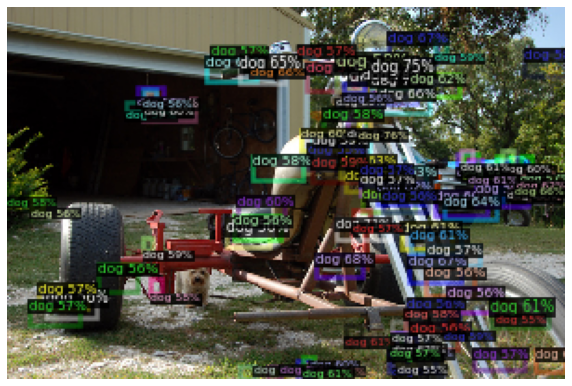

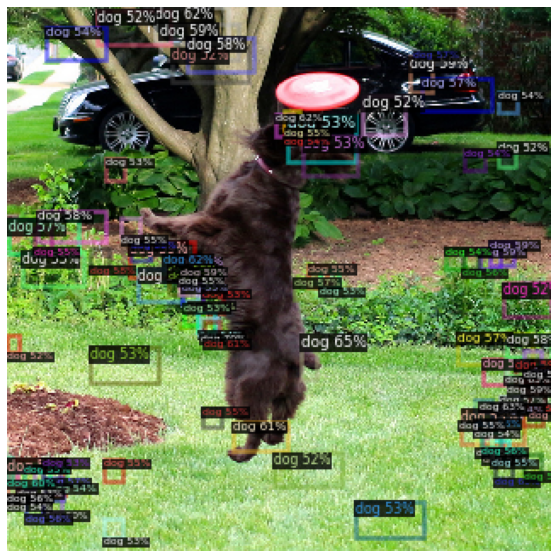

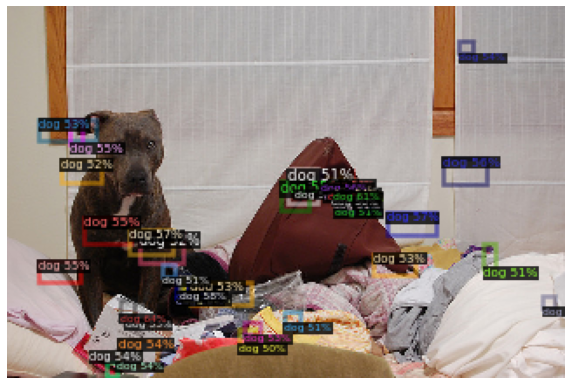

In [8]:
predictor = DefaultPredictor(cfg)

dataset_dicts = DatasetCatalog.get("coco_val_dog")

for d in dataset_dicts[:3]:
    img = cv2.imread(d["file_name"])
    
    # Get model predictions
    outputs = predictor(img)
    
    # Visualize the predictions
    v = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("coco_val_dog"), scale=0.5)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(out.get_image())
    plt.axis("off")
    plt.show()